In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import torch
import torch.nn as nn
import torchvision
from torchvision.ops import box_iou
import dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from model import ResNet18YOLOv1
from tqdm import tqdm
from evaluate import get_bboxes, mean_average_precision
from loss import YOLOv1Loss

In [25]:
pascal_voc_train = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="train",
    download=False
)

In [26]:
voc_train = dataset.PascalVOC(pascal_voc=pascal_voc_train)

In [27]:
data = voc_train[0]
resize = torchvision.transforms.Resize((448, 448))

data = (resize(data[0]).unsqueeze(0), data[1].unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.0000, 0.5490, 0.8574, 0.3900, 0.5195, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


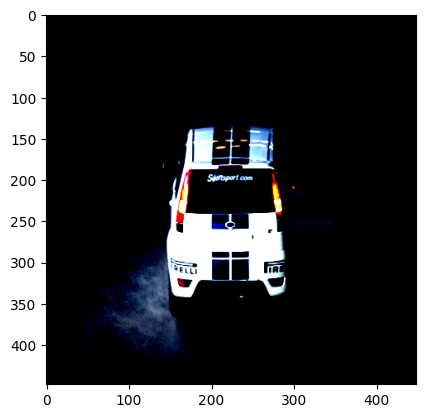

In [28]:
img = data[0].squeeze(0).permute((1, 2, 0))
Y = data[1][0][3][3]
print(Y)

plt.imshow(img)

In [29]:
device = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    
print(device)

yolo = ResNet18YOLOv1().to(device)
yolo_loss = YOLOv1Loss()

mps


In [30]:
X = data[0].to(device)
Y = data[1].to(device)
pred = yolo(X)
yolo_loss(pred, Y)

tensor(17.8228, device='mps:0', grad_fn=<DivBackward0>)

In [31]:
torch.mps.empty_cache()

In [123]:
print("TRAINING")
losses = []
EPOCHS = 20
optimizer = torch.optim.SGD(yolo.parameters(), lr=1e-6, weight_decay=0.0000, momentum=0.9)
# optimizer = torch.optim.Adam(yolo.parameters(), lr=1e-5, weight_decay=0.0005)

yolo.train()

for epoch in range(EPOCHS):
    X, Y = data
    
    X = X.to(device)
    Y = Y.to(device)
    
    pred = yolo(X)
    loss = yolo_loss(pred, Y)
    
    
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    
    # calculate mAP
    # print(pred.shape, Y.shape)
    # pred_bboxes = get_bboxes(pred[0])    
    # target_bboxes = get_bboxes(Y[0], B=1)
    # mAP = mean_average_precision([pred_bboxes], [target_bboxes])
    
    print(f"EPOCH {epoch + 1}: Loss={loss}")

TRAINING
EPOCH 1: Loss=0.9521492719650269
EPOCH 2: Loss=0.862291693687439
EPOCH 3: Loss=1.0589269399642944
EPOCH 4: Loss=1.130649447441101
EPOCH 5: Loss=0.8857606649398804
EPOCH 6: Loss=0.84737229347229
EPOCH 7: Loss=0.8786557912826538
EPOCH 8: Loss=0.916488528251648
EPOCH 9: Loss=1.0135595798492432
EPOCH 10: Loss=0.7757129669189453
EPOCH 11: Loss=1.0728435516357422
EPOCH 12: Loss=1.192941665649414
EPOCH 13: Loss=0.9362608790397644
EPOCH 14: Loss=0.9055685997009277
EPOCH 15: Loss=0.9961973428726196
EPOCH 16: Loss=0.6458086967468262
EPOCH 17: Loss=0.726423442363739
EPOCH 18: Loss=0.8852700591087341
EPOCH 19: Loss=0.8120120167732239
EPOCH 20: Loss=1.0298635959625244


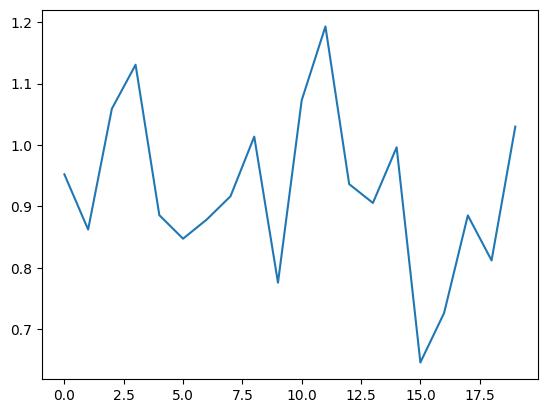

In [124]:
plt.plot(range(EPOCHS), losses)

In [125]:
yolo.eval()

yolo(X)[0][3][3]

tensor([0.7671, 0.5648, 0.8938, 0.4174, 0.4877, 0.5629, 0.5857, 0.8481, 0.5720,
        0.5580, 0.0675, 0.0715, 0.0589, 0.0605, 0.0540, 0.0558, 0.9310, 0.0568,
        0.0683, 0.0626, 0.0715, 0.0561, 0.0660, 0.0602, 0.0589, 0.0630, 0.0617,
        0.0660, 0.0753, 0.0651], device='mps:0', grad_fn=<SelectBackward0>)

In [126]:
yolo(X)[0][3][3][0::5]

tensor([0.7671, 0.5629, 0.0675, 0.0558, 0.0715, 0.0630], device='mps:0',
       grad_fn=<SliceBackward0>)

In [127]:
Y = data[1]
Y[0][3][3]

tensor([1.0000, 0.5490, 0.8574, 0.3900, 0.5195, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [128]:
target = pascal_voc_train[0][1]
target

{'annotation': {'folder': 'VOC2007',
  'filename': '000012.jpg',
  'source': {'database': 'The VOC2007 Database',
   'annotation': 'PASCAL VOC2007',
   'image': 'flickr',
   'flickrid': '207539885'},
  'owner': {'flickrid': 'KevBow', 'name': '?'},
  'size': {'width': '500', 'height': '333', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'car',
    'pose': 'Rear',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}}

In [129]:
pred = pred.view(-1, 30)
pred = pred.detach()
bboxes = []
grid_size = 448 / 7

for i in range(pred.size(0)):
    box_pred = pred[i]
    classification = box_pred[-20:]
    pred_boxes = box_pred[:-20].view(-1, 5)
    
    grid_y = i // 7
    grid_x = i % 7
    
    for box in pred_boxes:
        confidence = box[0]
        if confidence >= 0.5:
            # change box shape to
            x = box[1]
            y = box[2]
            w = box[3]
            h = box[4]
            
            # print(x, y, w, h)
            
            x_center = (grid_x + x) * grid_size
            y_center = (grid_y + y) * grid_size

            
            # print(x_center, y_center)
            
            width = w * 448
            height = h * 448
            
            xmin = x_center - width / 2
            xmax = x_center + width / 2
            ymin = y_center - height / 2
            ymax = y_center + height / 2
            
            # print(xmin, ymin, xmax, ymax)
            
            # print(box)
            # if row == 3 and col == 3:
            bbox = torch.tensor([confidence, xmin, ymin, xmax, ymax]).clamp(0, 448) # add classification to this as well
            bboxes.append(bbox)
            # print(classification)
            
bboxes = torch.stack(bboxes)
bboxes

tensor([[  0.7212, 123.7608, 137.4093, 337.5287, 361.4553],
        [  0.7109, 153.4489, 136.8074, 319.4761, 357.3506]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


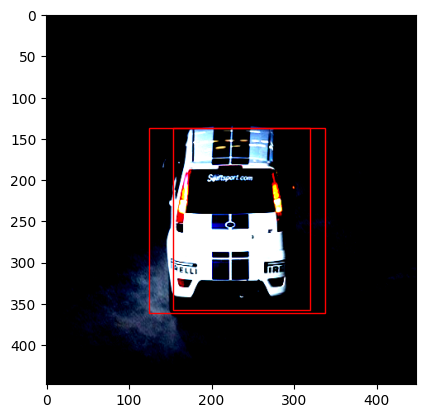

In [130]:
img = data[0].squeeze(0).permute((1, 2, 0))

fig, ax = plt.subplots()

for bbox in bboxes:
    bbox = bbox.numpy()
    xmin = bbox[1]
    ymin = bbox[2]
    width = bbox[3] - xmin
    height = bbox[4] - ymin
    
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


ax.imshow(img)